In [1]:
from copy import deepcopy

import gym
import accelerator_environments
import joss
import matplotlib.pyplot as plt
import numpy as np
import ocelot as oc

initializing ocelot...


In [2]:
ocelot_env = gym.make("ARESEA-Ocelot-v0")
joss_env = gym.make("ARESEA-JOSS-v0")

/usr/local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
print(f"Ocelot: {oc.generate_parray(nparticles=int(1e+5), sigma_x=175e-6, sigma_y=175e-6).rparticles.shape}")
print(f"JOSS: {joss.generate_particles(n=int(1e+5), sigma_x=175e-6, sigma_y=175e-6).shape}")

Ocelot: (6, 100000)
JOSS: (100000, 6)


In [4]:
actuator_values = np.array([5.5, -5.5, 0, 0, 0])

z = 6.654039999999998 / 6.654039999999998 : applied: Ocelot: 0.0002106472069706305 / 8.577356307969169e-05
FROM JOSS -> (100000, 6)
JOSS: 0.0002106472069706305 / 8.577356307969167e-05


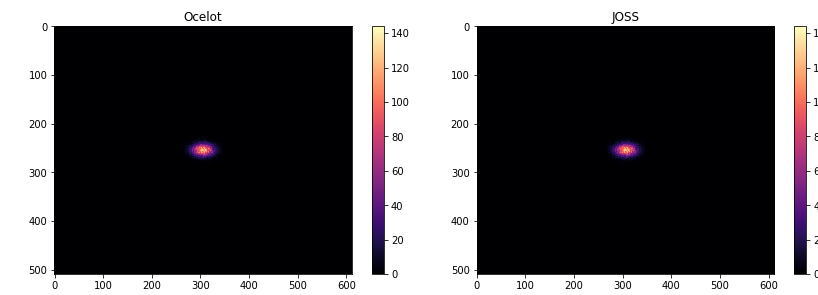

In [5]:
plt.figure(figsize=(12,4))
binning = 4
screen_resolution = (int(2448 / binning), int(2040 / binning))
meter_per_pixel = (3.5488e-6 * binning, 2.5003e-6 * binning)
screen_bin_edges = (np.linspace(-screen_resolution[0]*meter_per_pixel[0]/2,
                                             screen_resolution[0]*meter_per_pixel[0]/2,
                                             screen_resolution[0]+1),
                                 np.linspace(-screen_resolution[1]*meter_per_pixel[1]/2,
                                             screen_resolution[1]*meter_per_pixel[1]/2,
                                             screen_resolution[1]+1))

import accelerator_environments.envs.ares.ARESlatticeStage3v1_9 as aresstuff
from accelerator_environments import utils
cell = utils.subcell_of(aresstuff.cell, "AREASOLA1", "Drift_ARMRBSCR1")
aresstuff.areamqzm1.k1 = actuator_values[0]
aresstuff.areamqzm2.k1 = actuator_values[1]
aresstuff.areamqzm3.k1 = actuator_values[2]
# cell = [oc.Drift(l=3.0), oc.Quadrupole(l=1, k1=0), oc.Drift(l=0), oc.Drift(l=3)]
# cell = [oc.Drift(l=3.0)]

lattice = oc.MagneticLattice(cell)
navigator = oc.Navigator(lattice)
# particles = oc.generate_parray(nparticles=int(1e+5), sigma_x=175e-6, sigma_y=175e-6)
particles = oc.generate_parray(nparticles=int(1e+5), sigma_x=175e-6, sigma_y=175e-6, sigma_p=0., chirp=0., energy=0.1, sigma_tau=0.0)
particle_array = deepcopy(particles.rparticles)
_, particles = oc.track(lattice, particles, navigator)
image = np.histogram2d(particles.x(), particles.y(),
                       bins=screen_bin_edges)[0].transpose()
print(f"Ocelot: {particles.x().std()} / {particles.y().std()}")

plt.subplot(121)
plt.title("Ocelot")
plt.imshow(image, cmap="magma", interpolation="None")
plt.colorbar()

# particles = joss.generate_particles(n=int(1e+5), sigma_x=175e-6, sigma_y=175e-6)
particles = particle_array.transpose()
transfer_map = joss.ocelot_lattice_2_transfer_matrix(cell)
particles = joss.track(particles, transfer_map)
image = np.histogram2d(particles[:,0], particles[:,2],
                       bins=screen_bin_edges)[0].transpose()
print(f"JOSS: {particles[:,0].std()} / {particles[:,2].std()}")

plt.subplot(122)
plt.title("JOSS")
plt.imshow(image, cmap="magma", interpolation="None")
plt.colorbar()

plt.tight_layout()
plt.show()

[[-7.09520075e-01  8.44494713e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.29307232e-01  1.31988859e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.84394313e-02  4.28878871e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.29307232e-01  5.81929084e-01
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  1.48264606e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
FROM JOSS -> (100000, 6)
[ 5.5 -5.5  0.   0.   0. ]
JOSS environment: 0.0002092262315998992 / 8.597322568987e-05
Ocelot environment: 0.0002101348008860376 / 8.583731249699353e-05


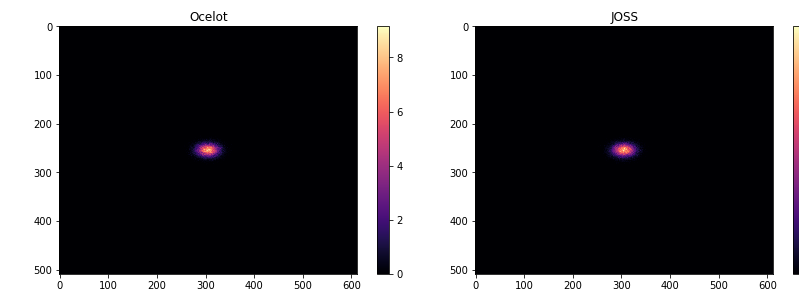

In [6]:
ocelot_env = gym.make("ARESEA-Ocelot-v0")
joss_env = gym.make("ARESEA-JOSS-v0")

# observation = ocelot_env.reset()
# _ = joss_env.reset()
joss_env.initial_particles = ocelot_env.initial_particles.rparticles.transpose()
# ocelot_env.initial_particles.rparticles = particle_array
# joss_env.initial_particles = particle_array.transpose()
_ = joss_env.objective_function(actuator_values)
_ = ocelot_env.objective_function(actuator_values)
print(actuator_values)

print(f"JOSS environment: {joss_env.particles[:,0].std()} / {joss_env.particles[:,2].std()}")
print(f"Ocelot environment: {ocelot_env.particles.x().std()} / {ocelot_env.particles.y().std()}")

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("Ocelot")
plt.imshow(ocelot_env.screen_data, cmap="magma", interpolation="None")
plt.colorbar()
plt.subplot(122)
plt.title("JOSS")
plt.imshow(joss_env.screen_data, cmap="magma", interpolation="None")
plt.colorbar()
plt.tight_layout()
plt.show()

In [10]:
np.all(joss_env.transfer_map == transfer_map)

True